In [1]:
import h5py
import os
import numpy as np

from keras.models import Model
from keras.utils import plot_model
import keras.backend as K
K.set_image_data_format('channels_last')

Using TensorFlow backend.


First, let's load the training and test data set that we created earlier. We also set a flag for whether the expected values are one-hot encoded classes or the range of coffee pot fullness (0.0 - 1.0).

In [2]:
is_regression = False

In [3]:
data_save_path = '../../data/coffee_video/label_data/v3'
class_data_set_name='coffee_class_data_v3.h5'
regression_data_set_name='coffee_regression_data_v3.h5'

In [4]:
def get_data(filepath):
    data_file = h5py.File(filepath,'r')

    train_data = data_file['train_data'][:]
    train_labels = data_file['train_labels'][:]

    test_data = data_file['test_data'][:]
    test_labels = data_file['test_labels'][:]

    return train_data, train_labels, test_data, test_labels

if(is_regression):
    filepath=os.path.join(data_save_path,regression_data_set_name)
else:
    filepath=os.path.join(data_save_path,class_data_set_name)

train_data, train_labels, test_data, test_labels  = get_data(filepath)

print('Training Data Shape:',train_data.shape)
print('Training Labels Shape:',train_labels.shape)

print('Test Data Shape:',test_data.shape)
print('Test Labels Shape:',test_labels.shape)

Training Data Shape: (94, 540, 960, 3)
Training Labels Shape: (94, 6)
Test Data Shape: (24, 540, 960, 3)
Test Labels Shape: (24, 6)


Now, let's define our model. Using keras, we define the first layer of the model based on the image dimensions, which would be (width, height, channels). After this, we add a series of 2D convolutional layers which consists of a covolution operation, a non-linear activation, and then a max pooling layer. Hyperparameters for the number of filters, filter size, etc. are defined in a list for each layer. The convolutional layers act as spatial feature detectors which learn different feature representations which will be used by the next steps.

Then, the output is flattened, and we add a number of dense fully connected layers that are also defined as a list. Each layer consists of the numbber of hidden units,  

Finally, we add the output layer. If we are using this as a multi-class problem (e.g. varying amounts of coffee pot fullness are bucketed and each is treated as a separate class), then our final output layers consists of a neuron for each class, with softmax activation. Otherwise, in the regression case (where we treat the output as a continuous variable), we add a dense layer with a single node which would output values betwen the range of 0-1. Mean squared error is then used as the loss function to train the network.

The model is defined in a JSON file. First, let's load the configuration.

In [7]:
import build_ishame_model

iShame_model_config = 'iShameModel.json'
conv_layers, conn_layers = build_ishame_model.load_model_def(iShame_model_config)
print("conv_layers",conv_layers)
print("conn_layers",conn_layers)

conv_layers [{'num_filters': 16, 'filter_size': '(5,5)', 'stride_size': '(2,2)', 'activation': 'relu', 'pool_size': '(2,2)'}, {'num_filters': 32, 'filter_size': '(5,5)', 'stride_size': '(2,2)', 'activation': 'relu', 'pool_size': '(2,2)'}, {'num_filters': 64, 'filter_size': '(5,5)', 'stride_size': '(2,2)', 'activation': 'relu', 'pool_size': '(2,2)'}]
conn_layers [{'hidden_units': 20, 'activation': 'relu', 'dropout': 0.5}, {'hidden_units': 10, 'activation': 'relu'}]


Now let's define some additional hyperparameters for our model, based on whether we are treating this as a classification or regression problem.

In [8]:
input_shape = train_data.shape[1:]
if(is_regression):
    num_classes=None
else:
    num_classes=train_labels.shape[-1]
batch_size=32
epochs=1

We're now ready to build our model.

In [9]:
model = build_ishame_model.build_model(input_shape=input_shape, \
                                        conv_layers=conv_layers, \
                                        conn_layers=conn_layers, \
                                        output_classes=num_classes)
build_ishame_model.compile_model(model, is_regression)

Let's take a look at the different layers. We can the convolutional and fully connected layers defined in the config have been successfully created. 

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 268, 478, 16)      1216      
_________________________________________________________________
max_pool_0 (MaxPooling2D)    (None, 134, 239, 16)      0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 65, 118, 32)       12832     
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 32, 59, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 14, 28, 64)        51264     
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 7, 14, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

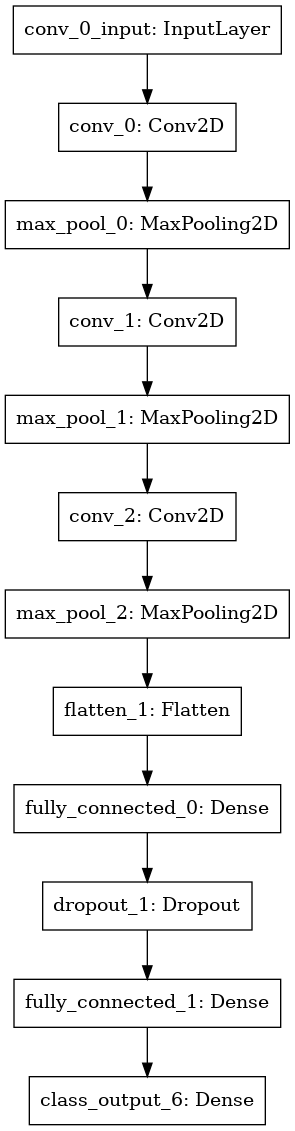

In [11]:
plot_model(model)

Now, we train our model with the given training data and hyperparameters.

In [12]:
model.fit(train_data, train_labels, epochs = epochs, batch_size = batch_size)

Epoch 1/1
94/94 [==============================] - 28s 296ms/step - loss: 1.8348 - categorical_accuracy: 0.1596



Let's verify our model performance by checking our performance on our holdout set.

In [13]:
results = model.evaluate(test_data, test_labels)
print("Loss:",results[0])
print("Metric:",results[1])

24/24 [==============================] - 3s 120ms/step
Loss: 1.8005009889602661
Metric: 0.25


In [14]:
model_save_path = '../../data/coffee_video/model'

if(is_regression):
    model_weights_filename='coffee_regression_v3_sequential_weights.h5'
else:
    model_weights_filename='coffee_class_v3_sequential_weights.h5'

model_weights_path = os.path.join(model_save_path,model_weights_filename)

model.save_weights(model_weights_path)


Let's check that we can reload the model, using the new weights file.

In [15]:
import build_ishame_model

loaded_model = build_ishame_model.load_model_with_weights(iShame_model_config, model_weights_path, input_shape, num_classes)

In [16]:
loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 268, 478, 16)      1216      
_________________________________________________________________
max_pool_0 (MaxPooling2D)    (None, 134, 239, 16)      0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 65, 118, 32)       12832     
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 32, 59, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 14, 28, 64)        51264     
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 7, 14, 64)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)             

In [17]:
build_ishame_model.compile_model(loaded_model, is_regression)

In [20]:
print(loaded_model.weights[0])

<tf.Variable 'conv_0_1/kernel:0' shape=(5, 5, 3, 16) dtype=float32, numpy=
array([[[[-0.08971665,  0.10573822,  0.076139  , ...,  0.04298963,
           0.11218297, -0.00976407],
         [ 0.11041723,  0.04439364,  0.05929168, ...,  0.0911869 ,
          -0.03173469,  0.07411268],
         [ 0.04021044, -0.06648307, -0.07854948, ...,  0.03538447,
           0.10937838, -0.02455902]],

        [[-0.01792108,  0.02327688, -0.07760806, ...,  0.02442818,
          -0.10660453,  0.10060924],
         [-0.06438684, -0.00628485,  0.03384824, ...,  0.05191742,
           0.08070631,  0.0324304 ],
         [-0.10377873,  0.08062913, -0.01823493, ..., -0.0869029 ,
          -0.03097877, -0.06957727]],

        [[-0.00163544, -0.0246708 , -0.0718659 , ...,  0.04290323,
           0.01911487, -0.00810969],
         [ 0.10275371,  0.08512391,  0.06573613, ...,  0.08349061,
          -0.01588028, -0.02286048],
         [-0.04582815,  0.04904307, -0.11260298, ..., -0.00278514,
          -0.08391336,

In [21]:
not_loaded_model = build_ishame_model.build_model(input_shape=input_shape, \
                                        conv_layers=conv_layers, \
                                        conn_layers=conn_layers, \
                                        output_classes=num_classes)
print(not_loaded_model.weights[0])

<tf.Variable 'conv_0_3/kernel:0' shape=(5, 5, 3, 16) dtype=float32, numpy=
array([[[[ 0.05758575, -0.10455653, -0.05028742, ...,  0.00039183,
           0.05966425,  0.08994262],
         [-0.02213931, -0.01942628, -0.02924136, ...,  0.02570046,
          -0.00947638, -0.04891424],
         [ 0.06890641,  0.09085894, -0.02511615, ..., -0.10197284,
           0.08518173,  0.09756893]],

        [[ 0.08619261,  0.03472178,  0.09725168, ...,  0.09026361,
           0.06136012,  0.05956803],
         [-0.06353466,  0.11198801, -0.05157655, ...,  0.10465257,
          -0.04181375, -0.01879805],
         [-0.06408655, -0.02012423, -0.04956165, ...,  0.09856373,
           0.01044904, -0.07670237]],

        [[ 0.09880003,  0.06769985,  0.03370668, ..., -0.09389193,
           0.0536879 , -0.04762798],
         [-0.04539454, -0.01800692, -0.09245946, ..., -0.05871817,
           0.05882342, -0.04171259],
         [-0.00849501, -0.02917881,  0.09443429, ..., -0.01388855,
          -0.04885796,